# Create Confusion Matrix

In [20]:
from BCM_dataset_v2 import bcmDataset
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt


In [11]:
# Load a previously trained model

from BCM_dataset_v2 import concat_train_test_datasets


model_loaded = torch.jit.load('trained_models/oct_6_3_sec_window')
model_loaded.eval()

# Create a dataset
#ds = bcmDataset('data/bcm/4.npy', class_id = 4, window_size = 3, stride = 3, MFCC_stride = 0.032)
_, ds = concat_train_test_datasets('data/bcm', window_size = 3, MFCC_stride = 0.032)


Validation set
data/bcm/validation/0.npy
data/bcm/validation/1.npy
data/bcm/validation/2.npy
data/bcm/validation/3.npy
data/bcm/validation/4.npy
Training set
data/bcm/train/0.npy
data/bcm/train/1.npy
data/bcm/train/2.npy
data/bcm/train/3.npy
data/bcm/train/4.npy


In [12]:

preds = np.zeros(len(ds))
y = np.zeros(len(ds))


for i in range(0, len(ds)):
    # Remeber to insert empty/None dimension to test a single datapoint!!!!!!!!!
    test = ds[i][0]
    test = test[None,:,:]
    preds[i] = model_loaded(test).argmax()
    y[i] = ds[i][1].argmax()
    
# Cell takes approx 6 mins to run


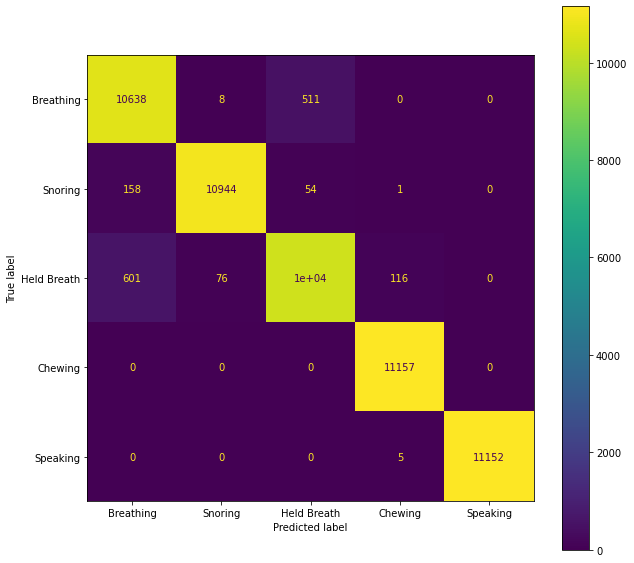

In [35]:
conf_mat = confusion_matrix(y, preds)
fig, ax = plt.subplots(figsize=(10, 10))

cm = confusion_matrix(y, preds, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Breathing','Snoring','Held Breath','Chewing','Speaking'])
fig.patch.set_facecolor('white')
disp.plot(ax = ax)



>>> predictions = clf.predict(X_test)
>>> cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
>>> disp = ConfusionMatrixDisplay(confusion_matrix=cm,
...                               display_labels=clf.classes_)
>>> disp.plot()
<...>
>>> plt.show()